<a href="https://colab.research.google.com/github/jferx/DeteccionEnfermedadPapa/blob/main/Reconocimiento_de_Enfermedades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 40

In [ ]:
!apt install unzip
!unzip /content/archive.zip

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory("/content/PLD_3_Classes_256/Training",
                                                     shuffle=True,
                                                     batch_size = BATCH_SIZE,
                                                     image_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 3251 files belonging to 3 classes.


In [8]:
classes = dataset.class_names
classes

['Early_Blight', 'Healthy', 'Late_Blight']

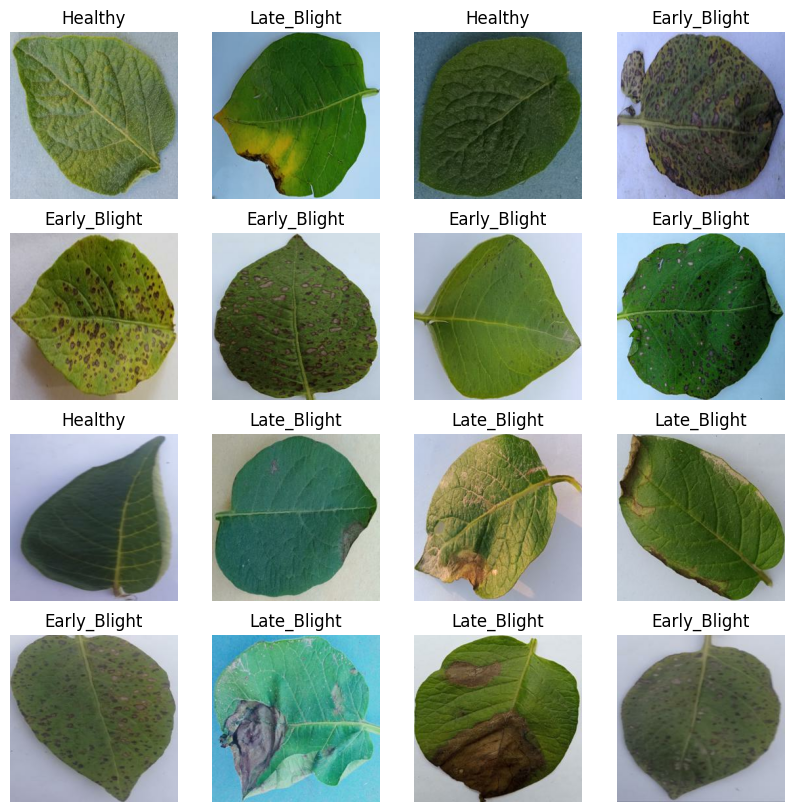

In [9]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(classes[label[i]])
        plt.axis("off")

In [10]:
def dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if(shuffle):
        ds = ds.shuffle(shuffle_size,seed=8)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds = dataset_partition(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=["accuracy"]
)

In [18]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
81/81 [==============================] - 25s 115ms/step - loss: 1.0157 - accuracy: 0.4634 - val_loss: 0.8737 - val_accuracy: 0.5813
Epoch 2/40
81/81 [==============================] - 5s 60ms/step - loss: 0.7732 - accuracy: 0.6778 - val_loss: 0.6228 - val_accuracy: 0.7500
Epoch 3/40
81/81 [==============================] - 5s 59ms/step - loss: 0.6409 - accuracy: 0.7425 - val_loss: 0.6101 - val_accuracy: 0.7719
Epoch 4/40
81/81 [==============================] - 5s 61ms/step - loss: 0.5282 - accuracy: 0.7964 - val_loss: 0.4379 - val_accuracy: 0.8406
Epoch 5/40
81/81 [==============================] - 5s 59ms/step - loss: 0.3877 - accuracy: 0.8589 - val_loss: 0.3257 - val_accuracy: 0.8813
Epoch 6/40
81/81 [==============================] - 5s 58ms/step - loss: 0.2769 - accuracy: 0.9015 - val_loss: 0.1615 - val_accuracy: 0.9406
Epoch 7/40
81/81 [==============================] - 5s 60ms/step - loss: 0.2359 - accuracy: 0.9166 - val_loss: 0.1887 - val_accuracy: 0.9344
Epoch 8/40


In [20]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 3s 26ms/step - loss: 0.0481 - accuracy: 0.9801


In [21]:
scores

[0.0481417290866375, 0.9801136255264282]

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

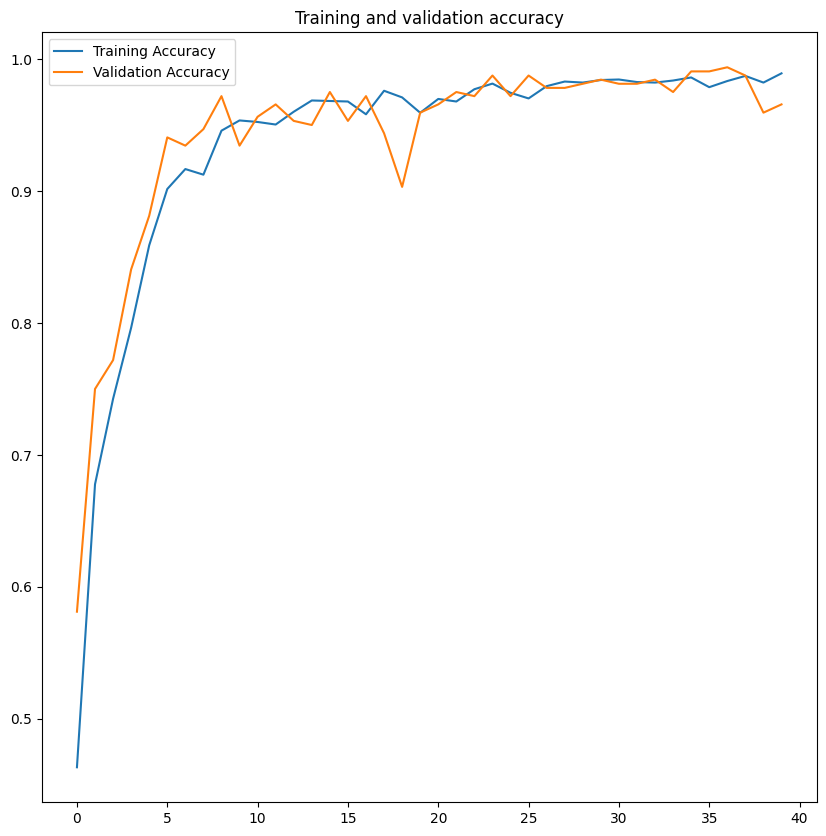

In [24]:
plt.figure(figsize=(10,10))
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend()
plt.title("Training and validation accuracy")

In [25]:
def predict(model,img):
    image = tf.keras.utils.img_to_array(img)
    image = tf.expand_dims(image,0)
    
    pred = model.predict(image)
    pred_class = classes[np.argmax(pred[0])]
    confidence = round(100 * (np.max(pred[0])),2)
    return pred_class,confidence

In [26]:
y_test = []
y_pred = []

for image_batch,label_batch in test_ds.take(1):
    y_test = label_batch[:]
    pred = model.predict(image_batch)
    y_pred = [np.argmax(i) for i in pred]
# confusion matrix calculation
cm = confusion_matrix(y_test,y_pred)
cm

1/1 [==============================] - 0s 152ms/step


array([[13,  0,  0],
       [ 0,  7,  0],
       [ 0,  0, 12]])

<Axes: >

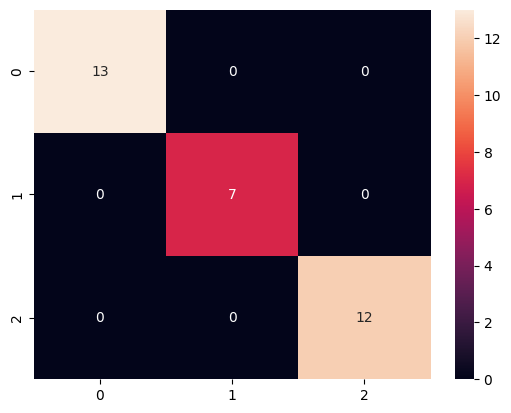

In [27]:
# visualize confusion matrix
sns.heatmap(cm,annot=True)

1/1 [==============================] - 0s 19ms/step


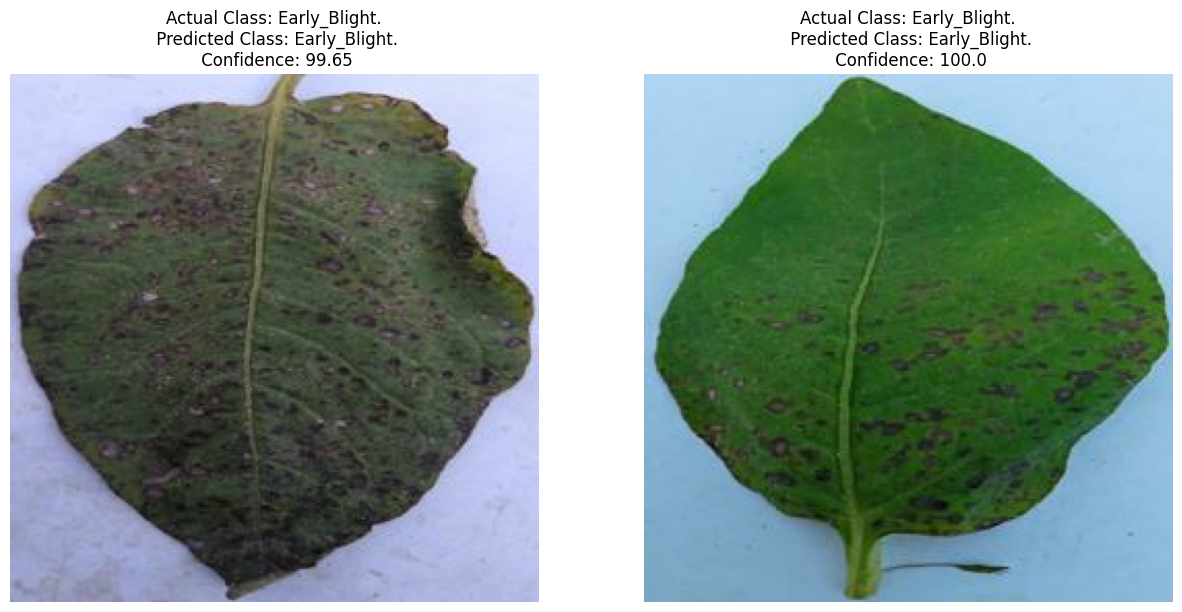

In [60]:
plt.figure(figsize=(15,20))
for image_batch,label_batch in test_ds.take(1):
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        pred_class,confidence = predict(model,image_batch[i].numpy());
        actual_class = classes[label_batch[i]]
        plt.title(f"Actual Class: {actual_class}.\n Predicted Class: {pred_class}.\n Confidence: {confidence}")
        plt.axis("off")

1/1 [==============================] - 0s 35ms/step


Text(0.5, 1.0, 'Predicted Class: Healthy.\n Confidence: 99.97')

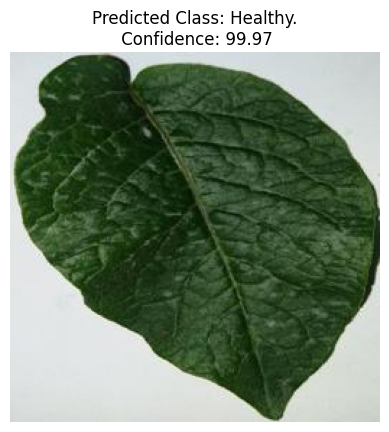

In [70]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = cv.imread("/content/Healthy_1.jpg")
image1="/content/Healthy_1.jpg"
img = cv.imread(image1)
im_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.axis("off")

image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
pred = model.predict(image)
   
pred_class = classes[np.argmax(pred[0])]
confidence = round(100 * (np.max(pred[0])),2)
classes[np.argmax(pred[0])]

plt.title(f"Predicted Class: {pred_class}.\n Confidence: {confidence}")



In [ ]:
model.save("saved_model")